## __Text mining y Procesamiento de Lenguaje Natural (NLP)__

__Profesor__: Anthony D. Cho

__Tema__: Analisis semantico

__Método__: Latent Semantic Analysis (LSA)

***

__Dependencias__

```{python}
    python -m pip install nltk spacy
    python -m spacy download en_core_web_sm
    python -m spacy download es_core_news_sm
```

## Librerias

In [2]:
import re
import joblib
from glob import glob
import matplotlib.pyplot as plt
from pandas import DataFrame

from string import punctuation
from spacy.lang.es.stop_words import STOP_WORDS
from spacy import load

from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import svd
from numpy import dot, diag

## Instancia del modelo de lenguaje
nlp = load('es_core_news_sm')

## Carga de documentos

In [9]:
## Encontrar la ruta de cada archivo de interes
path_docs = glob('*/doc*.txt')

## Almacenamiendo de contenido de los documentos e id (nombre del archivo)
corpus, doc_id = [], [] 

## Incio de proceso de carga de documentos
if len(path_docs):
    for file in path_docs:

        ## Se carga el texto
        text = open(file, 'r', encoding='utf-8').read()
        
        ## Se almacena el texto
        corpus.append(text)
        
        id = file.split('\\')[-1].split('.')[0]

        ## Se almacena el id
        doc_id.append(id)
else:
    print('No corpus have found.')

In [3]:
doc_id

['doc1', 'doc2', 'doc3', 'doc4', 'doc5', 'doc6', 'doc7']

#### Preprocesamiento

In [12]:
## Limpieza de textos
cleanTexts = []

for doc in corpus:

    # ## Remover numeros y puntuaciones
    doc = re.sub(r'[\"\¿\°\d+]', '', doc)
    doc = [s for s in doc if s not in punctuation]
    doc = ''.join(doc)

    ## Normalización y remover stopwords
    documento = nlp(doc.lower())
    tokens = [word.text for word in documento]
    doc = [word for word in tokens if word not in STOP_WORDS]
    doc = ' '.join(doc)
    doc = re.sub(pattern='\s+', repl=' ', string=doc)
    
    ## Aplicar lemmatización
    documento = nlp(doc)
    lemmas = [word.lemma_ for word in documento]
    doc = ' '.join(lemmas)
    doc = re.sub(pattern='\s+', repl=' ', string=doc)

    ## Almacenado de contenido procesado
    cleanTexts.append(doc)

## Mostar contenido procesado
cleanTexts
    

['laptop año reciente impacto xps comenzar carrera bisel delgado cosa influir absolutamente dispositivo contar pantalla versión reciente dell llevado cosa lejos xps ampliado pantalla relación aspecto encoger bisel inferior resultado pantalla laptop tamaño xps año teclado touchpad aprovechar superficie posible dispositivo poderoso duradero sacrificar funcionalidad diseño barata duda ganado lugar opción premium definitivamente laptop poder comprar xps empezar core ig gb ram gb ssd pantalla full hd x pixel configurada core ig gb ram tb almacenamiento pantalla oled',
 'ver macbook air reciente desviación mac año macbook pro mac mini macbook air funcionar silicio apple chip m costo procesador m aportar ventaja importante macbook air convirtiéndola portátil perfecto estudiante chip m poder configurar él gb ram tb ssd mejora traer chip m duración rendimiento bateer viejo macbook air incapacitado procesador lento doble núcleo utilizado mantener sistema completamente ventilador apple realizar t

In [26]:
## Instancia del modelo
model = TfidfVectorizer()

## Ajuste del modelo y retorno de TF matrix como (term, docs)
tf_sparse = model.fit_transform(cleanTexts).T

## Extraer la lista de los palabras que representan las columnas de la matriz generada
vocabulary = model.get_feature_names_out()

print('(shape) tf (terms, docs): {}'.format(tf_sparse.shape))

(shape) tf (terms, docs): (322, 7)


In [19]:
## Aplicación del método SVD
U, sigma, Vt = svd(tf_sparse.toarray())

print('(shape) U: {} - sigma: {} - Vt: {}'.format(U.shape, sigma.shape, Vt.shape))
print(sigma)

(shape) U: (322, 322) - sigma: (7,) - Vt: (7, 7)
[1.19265319 1.01714604 1.00155152 0.98296618 0.96344509 0.937058
 0.87599098]


In [29]:
## Tamaño del espacio latente
n_latente = 2

## Computo de la matriz (Terms, latent features)
termsMatrix = dot( U[:, :n_latente],
                    diag( sigma[:n_latente] )
                    )

## Computo de la matriz  (docs, latent features)
docMatrix = dot( diag( sigma[:n_latente] ),
                    Vt[:n_latente, :],
                ).T

print('(shape) termsMatrix: {} - docMatrix: {}'.format(termsMatrix.shape, docMatrix.shape))

(shape) termsMatrix: (322, 2) - docMatrix: (7, 2)


In [30]:
## Exportar construcción a archivo formato joblib (opcional)
data = {'sigma': sigma,
        'terms': termsMatrix,
        'docs': docMatrix,
        'vocabulary': vocabulary}

joblib.dump(value=data, filename='LSA_model', compress=9)

['LSA_model']

In [31]:
docMatrix

array([[-0.44519135,  0.13748366],
       [-0.6104172 , -0.11020805],
       [-0.53727956,  0.0564949 ],
       [-0.61865452, -0.162426  ],
       [-0.41530732, -0.01982383],
       [-0.04877299,  0.72195065],
       [-0.07318079,  0.67257631]])

#### Mostrar nivel de importancia de los autovalores

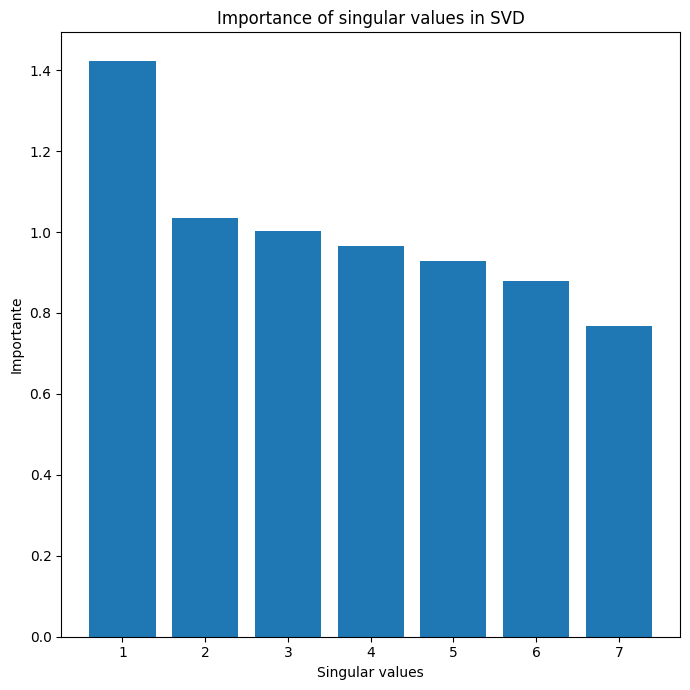

In [42]:
## List of index of values
setNumValues = range(1, len(sigma)+1)

## Importance list
importance = [x**2 for x in sigma]

## Display-space instance
plt.figure(figsize=(7,7))
plt.bar(setNumValues, importance)
plt.ylabel('Importante'); plt.xlabel('Singular values')
plt.title('Importance of singular values in SVD')
plt.tight_layout()
plt.show()

In [34]:
def vectorsVisualizer(vocabulary, vectors):
    """
        DESCRIPTION:
            2D-vector visualizer. The first 2 coordinates are taken for visualizing.
        
        INPUT:
            @param vocabulary: list of terms
            @type vocabulary: list
            
            @param vectors: latent space matrix representation
            @type vectors: numpy.ndarray
        
        OUTPUT:
            Scattered graphic
        
    """
    
    ## Pairs (x,y) allocation
    x, y = [], []
    for v in vectors:
        x.append( v[0] )
        y.append( v[1] )
    
    ## Display-space instance
    plt.figure(figsize=(7,7))
    plt.title('Vector representation')
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(text=vocabulary[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom'
                     )
    plt.xlabel('latent feature 1'); plt.ylabel('latent feature 2');
    plt.tight_layout()
    plt.show()

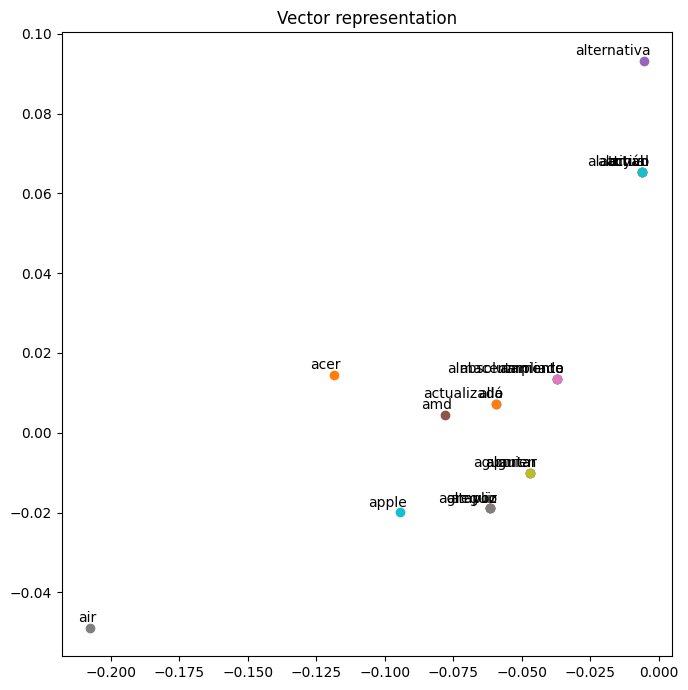

In [35]:
## Terms visualizer
vectorsVisualizer(vocabulary, termsMatrix[:20])

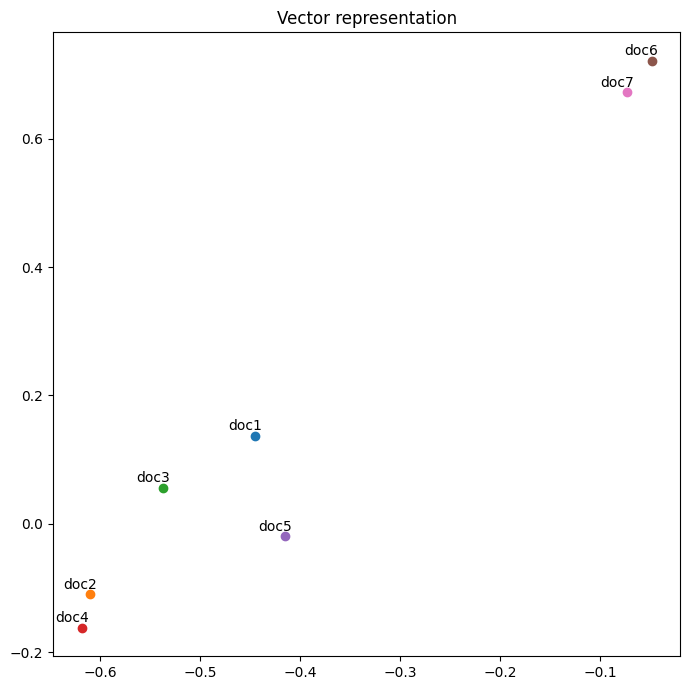

In [41]:
## docs visualizer
vectorsVisualizer(doc_id, docMatrix)

In [39]:
## Construcción de un dataframe del vcabulario con los pesos del espacio latente
terms = DataFrame(data=termsMatrix, index=vocabulary)
terms

,0,1
absolutamente,-0.037239,0.013484
acer,-0.118510,0.014611
activo,-0.006075,0.065465
actual,-0.006075,0.065465
actualizado,-0.059255,0.007306
...,...,...
volver,-0.061595,-0.018962
web,-0.061595,-0.018962
xps,-0.148956,0.053938
él,-0.044185,0.046055


In [40]:
## Construcción de un dataframe de los documentos con los pesos del espacio latente
docs = DataFrame(data=docMatrix, index=doc_id)
docs

,0,1
doc1,-0.445191,0.137484
doc2,-0.610417,-0.110208
doc3,-0.537280,0.056495
doc4,-0.618655,-0.162426
doc5,-0.415307,-0.019824
doc6,-0.048773,0.721951
doc7,-0.073181,0.672576


In [4]:
## Columns selection
import pandas as pd
columns = ['title', 'synopsis', 'genre', 'img_url']

## Load data
data = pd.read_csv('animes.csv', usecols=columns).dropna()

## resampling
data = data.sample(n=2000, random_state=20221026)

## Display number of rows and columns
print('(Shape) data: {}'.format(data.shape))

#2-Construya la tabla de representación binaria de los géneros de los animes (si un anime tiene mas de un genero en una lista tomar cada genero por separado). 

## Generos
generos = data['genre'].str.split(',').explode().unique()

## Construcción de la tabla de representación binaria
generosMatrix = DataFrame(columns=generos, index=data.index)

## Llenado de la tabla
for i in generosMatrix.index:
    generosMatrix.loc[i, data.loc[i, 'genre'].split(',')] = 1

## Llenado de los valores faltantes
generosMatrix.fillna(0, inplace=True)

#3- Determine las reglas de asociación más relevantes que tienen entre los géneros.

## Importación de librerias
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Aplicación del algoritmo apriori
frequent_itemsets = apriori(generosMatrix, min_support=0.01, use_colnames=True)

## Aplicación de las reglas de asociación
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

## Visualización de las reglas de asociación
rules

(Shape) data: (2000, 4)
(Number of genres) 1063
